# Activity 5: Flare Intensity Assessment, Mapping, and Spatial Analysis

This notebook implements two different approaches for modeling the intensity and spatial distribution of solar flares:

- **Method 1**: Intensity estimation based on `total_counts` attribute
- **Method 2**: Intensity estimation based on `duration` and `energy_band` attributes

We will create intensity maps and compare the spatial variations between the two methods.


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

In [33]:
df = pd.read_csv('../../data/cleaned_solarflare_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset shape: (57997, 21)
Columns: ['flare_id', 'date', 'start_time', 'peak_time', 'end_time', 'duration', 'peak_counts_per_sec', 'total_counts', 'energy_band', 'x_pos', 'y_pos', 'radial', 'AR', 'flags', 'SESC_sunspot_number', 'sunspot_area', 'class_str', 'year', 'duration_min', 'flare_intensity', 'month']


## Method 1: Intensity Estimation Based on Total Counts

This method estimates flare intensity at specific locations (X_pos, Y_pos) using the `total_counts` attribute. The intensity is calculated as the sum of total counts for all flares within a spatial neighborhood around each location.


In [34]:
def method1_intensity_estimation(df, grid_size=50, radius=100):
    
    x_min, x_max = df['x_pos'].min(), df['x_pos'].max()
    y_min, y_max = df['y_pos'].min(), df['y_pos'].max()
    
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    
    intensity_grid = np.zeros((grid_size, grid_size))
    
    for i in range(grid_size):
        for j in range(grid_size):
            center_x, center_y = X_grid[i, j], Y_grid[i, j]
            
            distances = np.sqrt((df['x_pos'] - center_x)**2 + (df['y_pos'] - center_y)**2)
            nearby_flares = df[distances <= radius]
            
            intensity_grid[i, j] = nearby_flares['total_counts'].sum()
    
    return intensity_grid, x_grid, y_grid

print("Applying Method 1: Total Counts-based Intensity Estimation")
intensity_method1, x_grid1, y_grid1 = method1_intensity_estimation(df, grid_size=50, radius=150)

print(f"Method 1 Results:")
print(f"Grid shape: {intensity_method1.shape}")
print(f"Intensity range: {intensity_method1.min():.0f} to {intensity_method1.max():.0f}")
print(f"Mean intensity: {intensity_method1.mean():.0f}")
print(f"Total intensity: {intensity_method1.sum():.0f}")

Applying Method 1: Total Counts-based Intensity Estimation
Method 1 Results:
Grid shape: (50, 50)
Intensity range: 0 to 15187800139
Mean intensity: 1367598339
Total intensity: 3418995846600


## Method 2: Intensity Estimation Based on Duration and Energy Band

This method estimates flare intensity using both `duration` and `energy_band` attributes. The intensity is calculated as a weighted sum where:
- Higher energy bands contribute more to intensity
- Longer durations contribute more to intensity
- The combination provides a different perspective on flare intensity


In [35]:
def method2_intensity_estimation(df, grid_size=50, radius=100):
    
    energy_weights = {
        '6-12': 1.0,    
        '12-25': 2.0,   
        '25-50': 3.0,   
        '50-100': 4.0,  
        '100-300': 5.0, 
        '300-800': 6.0, 
        '800-7000': 7.0 
    }
    
    duration_normalized = df['duration'] / 3600
    
    df_weighted = df.copy()
    df_weighted['energy_weight'] = df_weighted['energy_band'].map(energy_weights)
    df_weighted['weighted_intensity'] = df_weighted['energy_weight'] * duration_normalized
    
    x_min, x_max = df['x_pos'].min(), df['x_pos'].max()
    y_min, y_max = df['y_pos'].min(), df['y_pos'].max()
    
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    
    intensity_grid = np.zeros((grid_size, grid_size))
    
    for i in range(grid_size):
        for j in range(grid_size):
            center_x, center_y = X_grid[i, j], Y_grid[i, j]
            
            distances = np.sqrt((df_weighted['x_pos'] - center_x)**2 + (df_weighted['y_pos'] - center_y)**2)
            nearby_flares = df_weighted[distances <= radius]
            
            intensity_grid[i, j] = nearby_flares['weighted_intensity'].sum()
    
    return intensity_grid, x_grid, y_grid

print("Applying Method 2: Duration and Energy Band-based Intensity Estimation")
intensity_method2, x_grid2, y_grid2 = method2_intensity_estimation(df, grid_size=50, radius=150)

print(f"Method 2 Results:")
print(f"Grid shape: {intensity_method2.shape}")
print(f"Intensity range: {intensity_method2.min():.2f} to {intensity_method2.max():.2f}")
print(f"Mean intensity: {intensity_method2.mean():.2f}")
print(f"Total intensity: {intensity_method2.sum():.2f}")


Applying Method 2: Duration and Energy Band-based Intensity Estimation
Method 2 Results:
Grid shape: (50, 50)
Intensity range: 0.00 to 1696.89
Mean intensity: 172.22
Total intensity: 430558.62


## Creating Intensity Maps

Now we'll create visualizations of the intensity maps using both methods. These maps will show the spatial distribution of flare intensity across the solar surface.


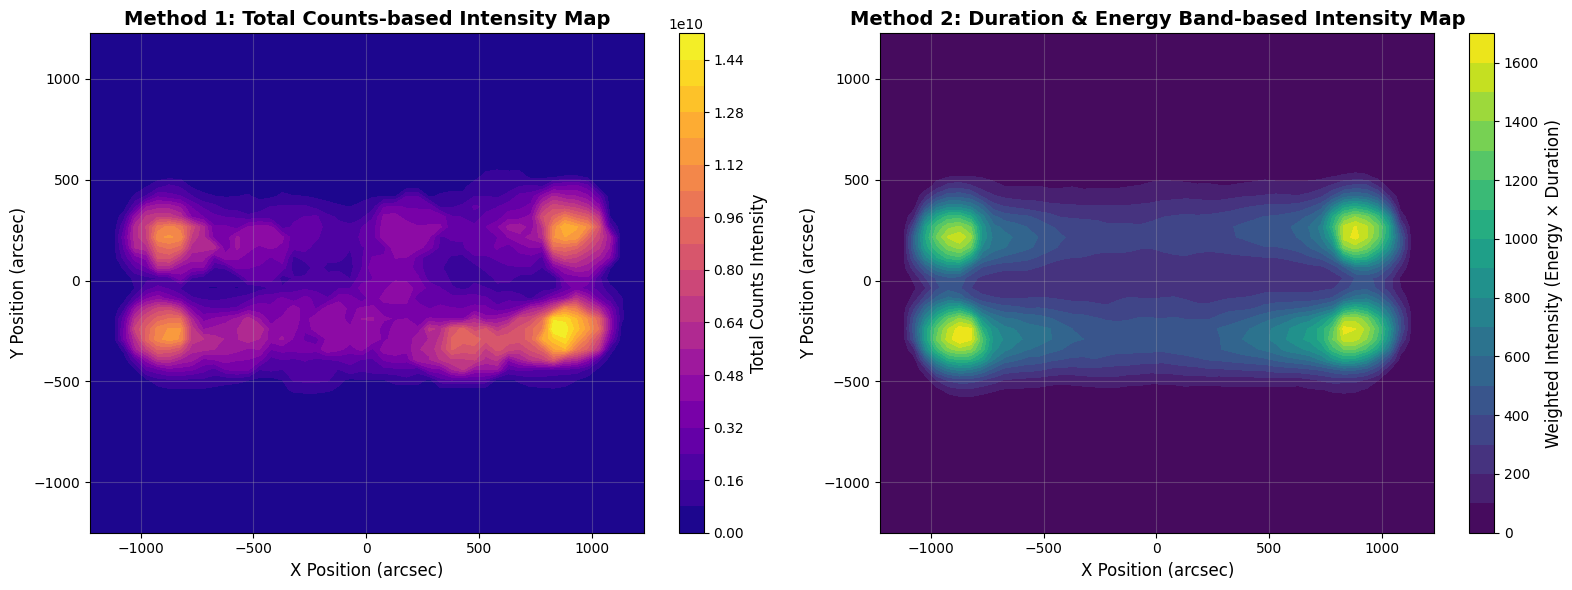

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

im1 = axes[0].contourf(x_grid1, y_grid1, intensity_method1, levels=20, cmap='plasma')
axes[0].set_title('Method 1: Total Counts-based Intensity Map', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X Position (arcsec)', fontsize=12)
axes[0].set_ylabel('Y Position (arcsec)', fontsize=12)
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Total Counts Intensity', fontsize=12)

im2 = axes[1].contourf(x_grid2, y_grid2, intensity_method2, levels=20, cmap='viridis')
axes[1].set_title('Method 2: Duration & Energy Band-based Intensity Map', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X Position (arcsec)', fontsize=12)
axes[1].set_ylabel('Y Position (arcsec)', fontsize=12)
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Weighted Intensity (Energy × Duration)', fontsize=12)

plt.tight_layout()
plt.savefig('visuals/intensity_maps_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

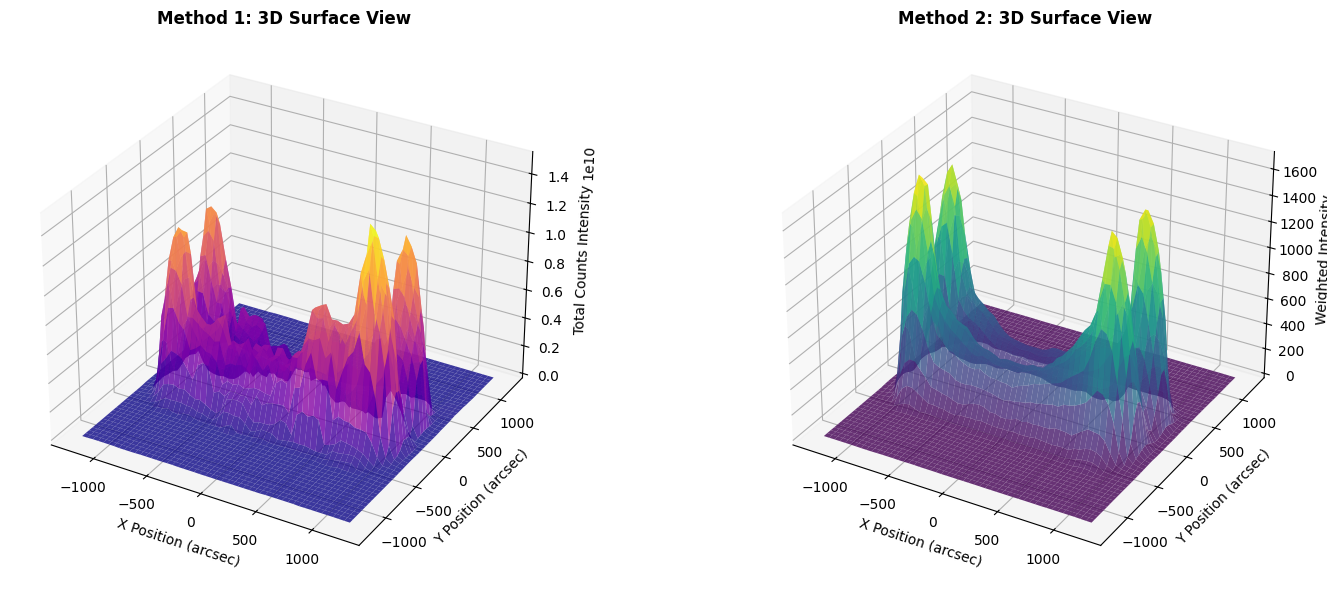

In [37]:
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121, projection='3d')
X1, Y1 = np.meshgrid(x_grid1, y_grid1)
surf1 = ax1.plot_surface(X1, Y1, intensity_method1, cmap='plasma', alpha=0.8)
ax1.set_title('Method 1: 3D Surface View', fontsize=12, fontweight='bold')
ax1.set_xlabel('X Position (arcsec)')
ax1.set_ylabel('Y Position (arcsec)')
ax1.set_zlabel('Total Counts Intensity')

ax2 = fig.add_subplot(122, projection='3d')
X2, Y2 = np.meshgrid(x_grid2, y_grid2)
surf2 = ax2.plot_surface(X2, Y2, intensity_method2, cmap='viridis', alpha=0.8)
ax2.set_title('Method 2: 3D Surface View', fontsize=12, fontweight='bold')
ax2.set_xlabel('X Position (arcsec)')
ax2.set_ylabel('Y Position (arcsec)')
ax2.set_zlabel('Weighted Intensity')

plt.tight_layout()
plt.savefig('visuals/intensity_maps_3d.png', dpi=300, bbox_inches='tight')
plt.show()


## Comparison of the Two Intensity Maps

Now we'll analyze and compare the spatial variations and total intensity between the two methods.


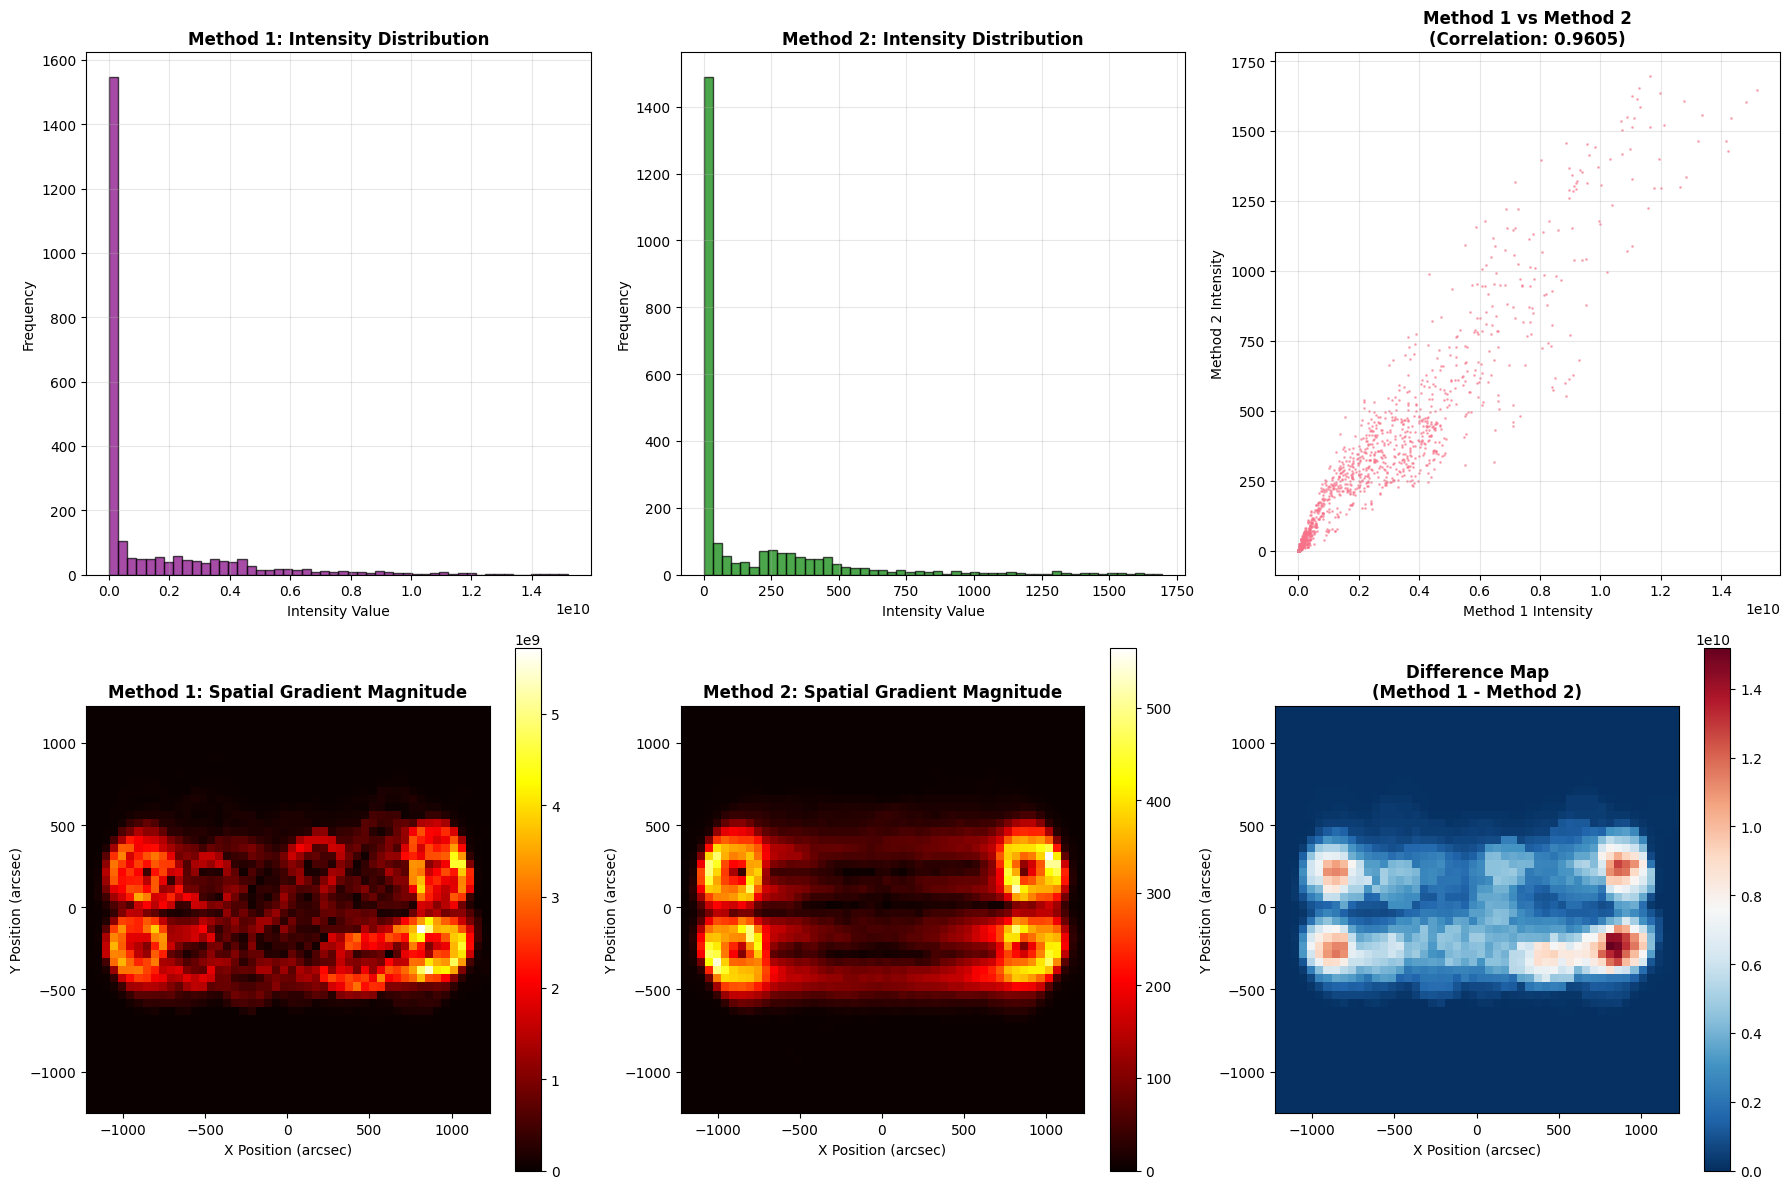

In [38]:
grad_x1, grad_y1 = np.gradient(intensity_method1)
grad_magnitude1 = np.sqrt(grad_x1**2 + grad_y1**2)

grad_x2, grad_y2 = np.gradient(intensity_method2)
grad_magnitude2 = np.sqrt(grad_x2**2 + grad_y2**2)

correlation = np.corrcoef(intensity_method1.flatten(), intensity_method2.flatten())[0, 1]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].hist(intensity_method1.flatten(), bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[0, 0].set_title('Method 1: Intensity Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Intensity Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(intensity_method2.flatten(), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Method 2: Intensity Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Intensity Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].scatter(intensity_method1.flatten(), intensity_method2.flatten(), alpha=0.5, s=1)
axes[0, 2].set_title(f'Method 1 vs Method 2\n(Correlation: {correlation:.4f})', fontweight='bold')
axes[0, 2].set_xlabel('Method 1 Intensity')
axes[0, 2].set_ylabel('Method 2 Intensity')
axes[0, 2].grid(True, alpha=0.3)

im1 = axes[1, 0].imshow(grad_magnitude1, extent=[x_grid1.min(), x_grid1.max(), y_grid1.min(), y_grid1.max()], 
                        origin='lower', cmap='hot')
axes[1, 0].set_title('Method 1: Spatial Gradient Magnitude', fontweight='bold')
axes[1, 0].set_xlabel('X Position (arcsec)')
axes[1, 0].set_ylabel('Y Position (arcsec)')
plt.colorbar(im1, ax=axes[1, 0])

im2 = axes[1, 1].imshow(grad_magnitude2, extent=[x_grid2.min(), x_grid2.max(), y_grid2.min(), y_grid2.max()], 
                        origin='lower', cmap='hot')
axes[1, 1].set_title('Method 2: Spatial Gradient Magnitude', fontweight='bold')
axes[1, 1].set_xlabel('X Position (arcsec)')
axes[1, 1].set_ylabel('Y Position (arcsec)')
plt.colorbar(im2, ax=axes[1, 1])

diff_map = intensity_method1 - intensity_method2
im3 = axes[1, 2].imshow(diff_map, extent=[x_grid1.min(), x_grid1.max(), y_grid1.min(), y_grid1.max()], 
                        origin='lower', cmap='RdBu_r')
axes[1, 2].set_title('Difference Map\n(Method 1 - Method 2)', fontweight='bold')
axes[1, 2].set_xlabel('X Position (arcsec)')
axes[1, 2].set_ylabel('Y Position (arcsec)')
plt.colorbar(im3, ax=axes[1, 2])

plt.tight_layout()
plt.savefig('visuals/intensity_comparison_analysis.png', dpi=300, bbox_inches='tight')
plt.show()